# Load the required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split   

from tensorflow.keras import models, layers 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2023-06-15 16:33:32.385408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Helper Functions

In [2]:
def model_evaluate(model, X_test, y_test):
    model = model
    model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_int = np.round(y_pred).astype(int)

    cm = confusion_matrix(y_test, y_pred_int)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [15]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['recall'], label='train' + exp_name)
    ax1.plot(history.history['val_recall'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('recall')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_title('Accuracy')
    ax2.legend()
    
    ax3.plot(history.history['loss'], label='train loss'  + exp_name)
    ax3.plot(history.history['val_loss'], label='val loss'  + exp_name)
    ax3.set_title('Loss')
    ax3.legend()
    
    return (ax1, ax2, ax3)

In [12]:
def get_image(item):
    file_name = f"../processed_data/{item['Cat']}/{item['image']}.jpg"
    image = Image.open(file_name)
    width, height=image.size
    assert (width==400 and height==400), f"image: {file_name}, width: {width}, height: {height}"
    # plt.imshow(image)
    # plt.show()
    return np.asarray(image, dtype=np.float32)


# Load Processed Data

### Load meta data

In [7]:
data = pd.read_csv('../processed_data/ISIC_2019_Training_GroundTruth_Processed.csv')
data.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,Cat,y
0,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
1,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1
2,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
3,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1
4,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0


the shape of the processed data setis (18331, 12)


<Axes: >

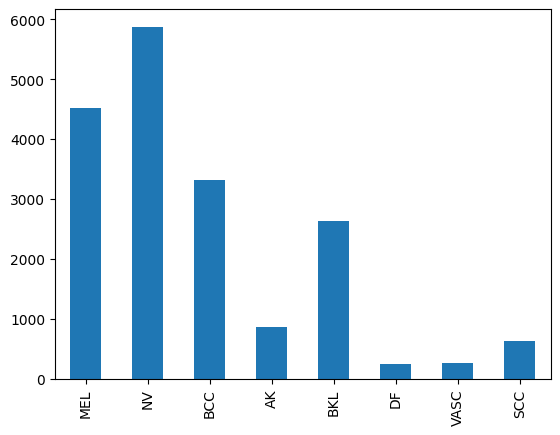

In [8]:
print(f'the shape of the processed data setis {data.shape}')
data.sum()[1:9].plot.bar()

### Load image data

In [13]:
n_samples=100; 
sample = data.sample(n_samples, random_state=42)
# sample = data #load the full dataset

X = sample.apply(get_image, axis=1)

X = np.stack(X)
y = sample.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70, 400, 400, 3) (30, 400, 400, 3) (70,) (30,)


### Load image data with arugmented data

In [ ]:
def get_argumented_images(samples):
    result = []
    for i in range(samples.shape[0]):
        item = samples.iloc[i]
        if item['Cat'] == 'AK' or item['Cat'] == 'SCC':
            file_name = f"../processed_data_reduce_NV/{item['Cat']}/{item['image']}.jpg"
            image = Image.open(file_name)
            for i in range(3):
                image = image.rotate(90)
                result.append(np.asarray(image, dtype=np.float32))
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            result.append(np.asarray(image, dtype=np.float32))       
    return result

n_samples=1000; 
samples = data.sample(n_samples, random_state=42)
samples_train, samples_test= train_test_split(samples)
print(samples_train.shape, samples_test.shape)

X_train = samples_train.apply(get_image, axis=1)
X_train = np.stack(X_train)
y_train = samples_train.y

arugmented_train_samples=np.stack(get_argumented_images(samples_train))

n_added = arugmented_train_samples.shape[0]
X_train = np.vstack((X_train, arugmented_train_samples))
y_train = pd.Series(list(y_train) + [1] * n_added)

# # sample = data #load the full dataset
print(arugmented_train_samples.shape,n_added)

X_test = samples_test.apply(get_image, axis=1)
X_test = np.stack(X_test)
y_test = samples_test.y
print( X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Modeling

## CNN Model

### build CNN Model

In [14]:
def initialize_CNN_model():
    
    model = models.Sequential()

    model.add(layers.Conv2D(16, (3, 3), input_shape = (400,400,3), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding='same' ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (2, 2), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(units = 100, activation = 'relu'))
    model.add(layers.Dense(units = 1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics =['accuracy', 'Recall'])   

    return model

### Train CNN Model

Epoch 1/10
4/4 [==============================] - 8s 2s/step - loss: 299.9234 - accuracy: 0.4082 - recall: 0.3000 - val_loss: 42.6227 - val_accuracy: 0.5238 - val_recall: 1.0000
Epoch 2/10
4/4 [==============================] - 6s 1s/step - loss: 20.9040 - accuracy: 0.6327 - recall: 1.0000 - val_loss: 20.0158 - val_accuracy: 0.4762 - val_recall: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 7s 2s/step - loss: 13.2356 - accuracy: 0.4286 - recall: 0.0667 - val_loss: 24.2035 - val_accuracy: 0.5238 - val_recall: 1.0000
Epoch 4/10
4/4 [==============================] - 6s 1s/step - loss: 18.2117 - accuracy: 0.4082 - recall: 0.4000 - val_loss: 33.2367 - val_accuracy: 0.5238 - val_recall: 1.0000
Epoch 5/10
4/4 [==============================] - 6s 1s/step - loss: 24.0298 - accuracy: 0.6122 - recall: 1.0000 - val_loss: 5.8600 - val_accuracy: 0.5238 - val_recall: 1.0000
Epoch 6/10
4/4 [==============================] - 6s 2s/step - loss: 2.8426 - accuracy: 0.5714 - recall: 0.7333

(<Axes: title={'center': 'recall'}>,
 <Axes: title={'center': 'Accuracy'}>,
 <Axes: title={'center': 'Loss'}>)

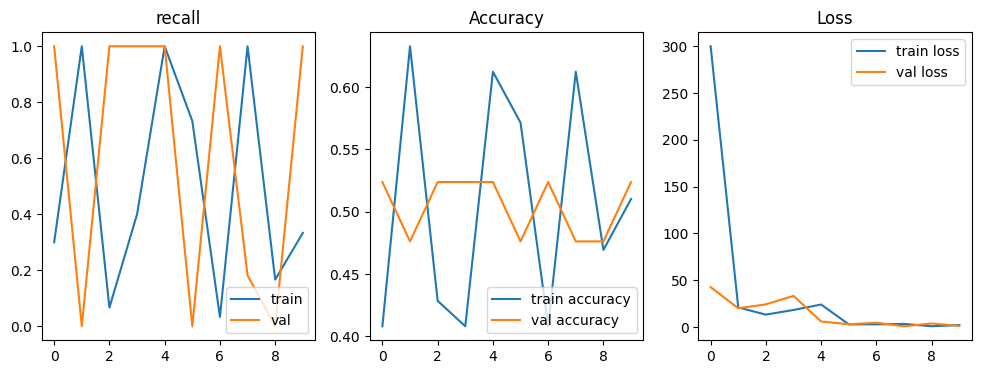

In [16]:
model_cnn = initialize_CNN_model()

es = EarlyStopping(patience=5, verbose=1)

history = model_cnn.fit(
    X_train, y_train,
    validation_split = 0.3,
    batch_size = 16,
    epochs=10,
    callbacks=[es],
    verbose = 1)

plot_history(history)

## VGG16 Transfer Learning

### Build VGG Model

In [17]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

def load_vgg_model():
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model

def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

def build_vgg_model():

    model = load_vgg_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall'])
    return model


### Data Preprocessing

In [18]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

### Train VGG Model

Epoch 1/10
2/2 [==============================] - 80s 36s/step - loss: 21.5696 - accuracy: 0.4898 - recall: 0.5333 - val_loss: 35.7273 - val_accuracy: 0.5238 - val_recall: 1.0000
Epoch 2/10
2/2 [==============================] - 64s 35s/step - loss: 4.8844 - accuracy: 0.7959 - recall: 0.9333 - val_loss: 5.1964 - val_accuracy: 0.4762 - val_recall: 0.3636
Epoch 3/10
2/2 [==============================] - 63s 33s/step - loss: 0.8607 - accuracy: 0.8980 - recall: 0.8333 - val_loss: 4.6566 - val_accuracy: 0.4762 - val_recall: 0.2727
Epoch 4/10
2/2 [==============================] - 62s 34s/step - loss: 0.0038 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 4.0557 - val_accuracy: 0.6190 - val_recall: 0.6364
Epoch 5/10
2/2 [==============================] - 60s 32s/step - loss: 1.8159e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 4.7004 - val_accuracy: 0.6667 - val_recall: 0.8182
Epoch 6/10
2/2 [==============================] - 60s 32s/step - loss: 3.3054e-07 - accuracy: 1.0000 - recall

(<Axes: title={'center': 'recall'}>,
 <Axes: title={'center': 'Accuracy'}>,
 <Axes: title={'center': 'Loss'}>)

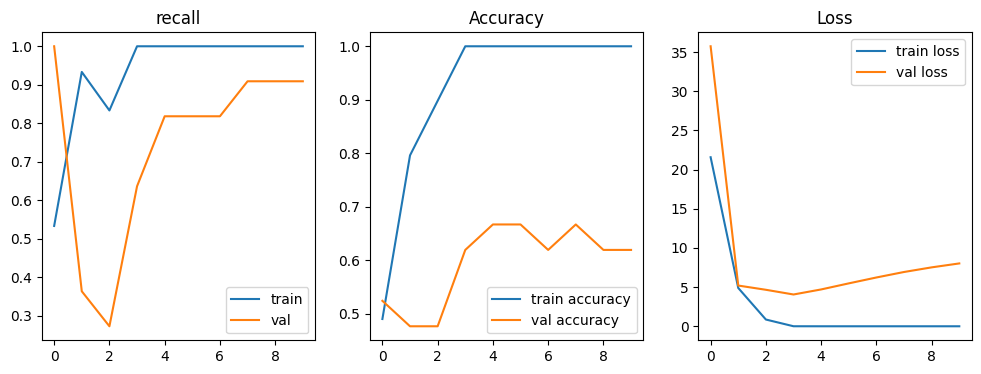

In [19]:
model_vgg = build_vgg_model()

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)
# 
history = model_vgg.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=10,
                    batch_size=32,
                    callbacks=[es])

plot_history(history)

## ResNET

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the pre-trained ResNet50 model without the top (fully connected) layers
def load_ResNet50_model():
    model = ResNet50(weights='imagenet', include_top=False, input_shape=X_train[0].shape)
    return model
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

In [24]:
def build_ResNet50_model():

    model = load_ResNet50_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall'])
    return model

In [25]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

Epoch 1/10
2/2 [==============================] - 38s 18s/step - loss: 20.0691 - accuracy: 0.5510 - recall: 0.6333 - val_loss: 17.7517 - val_accuracy: 0.5238 - val_recall: 0.4545
Epoch 2/10
2/2 [==============================] - 20s 12s/step - loss: 13.5905 - accuracy: 0.8367 - recall: 0.7333 - val_loss: 24.0611 - val_accuracy: 0.6190 - val_recall: 0.9091
Epoch 3/10
2/2 [==============================] - 22s 11s/step - loss: 1.3961 - accuracy: 0.9388 - recall: 0.9667 - val_loss: 42.1705 - val_accuracy: 0.5714 - val_recall: 0.9091
Epoch 4/10
2/2 [==============================] - 21s 11s/step - loss: 0.8200 - accuracy: 0.9592 - recall: 1.0000 - val_loss: 41.0817 - val_accuracy: 0.5714 - val_recall: 0.9091
Epoch 5/10
2/2 [==============================] - 21s 11s/step - loss: 7.3276e-15 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 37.6191 - val_accuracy: 0.6190 - val_recall: 0.9091
Epoch 6/10
2/2 [==============================] - 20s 11s/step - loss: 1.0076e-31 - accuracy: 1.0000 - r

(<Axes: title={'center': 'recall'}>,
 <Axes: title={'center': 'Accuracy'}>,
 <Axes: title={'center': 'Loss'}>)

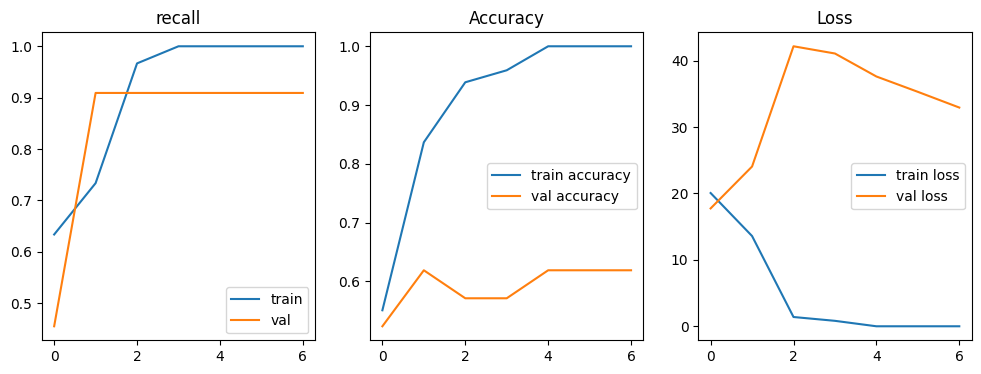

In [22]:
ResNet50_model = build_ResNet50_model()

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)
history = ResNet50_model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=10,
                    batch_size=32,
                    callbacks=[es])

plot_history(history)

## InceptionResNetV2

In [30]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

# Load the pre-trained ResNet50 model without the top (fully connected) layers
def load_InceptionResNetV2_model():
    model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=X_train[0].shape)
    return model

def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    augmentation = models.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1),
        # layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.1)
    ])

    model = models.Sequential([
        layers.Input(shape=X_train[0].shape),
        augmentation,
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model
def build_InceptionResNetV2_model():
    model = load_InceptionResNetV2_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall'])
    return model

In [27]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [32]:
model_InceptionResNetV2 = build_InceptionResNetV2_model()
lr = ReduceLROnPlateau(monitor="val_loss",
                       factor=0.1,
                       patience=2,
                       verbose=1,
                       min_lr=0)

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 10,
                   verbose = 1,
                   restore_best_weights = True)

history = model_InceptionResNetV2.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=10,
                    batch_size=16,
                    callbacks=[es, lr])
plot_history(history)

Epoch 1/10
4/4 [==============================] - 51s 9s/step - loss: 26.8108 - accuracy: 0.4898 - recall: 0.6667 - val_loss: 36.1356 - val_accuracy: 0.4762 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/10
2/4 [==============>...............] - ETA: 14s - loss: 39.9503 - accuracy: 0.4062 - recall: 0.0500    

## Evaluate Model

# Save the trained model

In [ ]:
# Serialize the trained model
model_name= 'model_dummy'